# Q&A Seizure Detection project

In [2]:
import os
import os.path as op

from download import download

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import classification_report

from mne_features.feature_extraction import FeatureExtractor

print(__doc__)

Automatically created module for IPython interactive environment


In [3]:
def download_bonn_ieeg(path, verbose=False):
    base_url = 'http://epileptologie-bonn.de/cms/upload/workgroup/lehnertz/'
    urls = [('setC', 'N.zip'), ('setD', 'F.zip'), ('setE', 'S.zip')]
    paths = list()
    for set_name, url_suffix in urls:
        _path = download(op.join(base_url, url_suffix),
                         op.join(path, set_name), kind='zip', replace=False,
                         verbose=verbose)
        paths.append(_path)
    return paths


# Download the data to ``./bonn_data``:
paths = download_bonn_ieeg('./bonn_data')

### Question 1

You used the full length of the segments for your classification, and the results are indeed satisfactory. Now, in a real life application we might be interested in an algorithm detecting the onset of the seizure as soon as possible, in order for example to trigger a therapeutic intervention (electrical stimulation, drug delivery, etc). In this case we would also want to minimize false positives of course. Which method would be the best for segments as short as 200 points (slightly more than one second)?

First, I shortened the segments so that they only contained 200 points

In [15]:
data_segments = list()
labels = list()
sfreq = 173.61
for path in paths:
    fnames = [s for s in os.listdir(path) if s.lower().endswith('.txt')]
    for fname in fnames:
        _data = pd.read_csv(op.join(path, fname), sep='\n', header=None)
        data_segments.append(_data.values.T[None, ..., 0:200])
    if 'setE' in path: # Then, it's seizure data
        labels.append(np.ones((len(fnames),)))
    else:
        labels.append(np.zeros((len(fnames),)))
        
data = np.concatenate(data_segments)
y = np.concatenate(labels, axis=0) 

# Shape of extracted data:
print(data.shape) # 300 recordings of 4097 datapoints
print(y.shape) # Label for each recording

(300, 1, 200)
(300,)


Second, I tested the performance of the four classifiers on the shortened (200 points) dataset

In [16]:
selected_funcs = ['line_length', 'kurtosis', 'ptp_amp', 'skewness']

skf = StratifiedKFold(n_splits=5)
seed = 26

names = ['Random Forest','K-Nearest Neighbours','Naive Bayes','Support Vector Machine']
classifiers = [RandomForestClassifier(n_estimators=100,max_depth=4,random_state=seed),KNeighborsClassifier(n_neighbors=10),GaussianNB(),SVC(kernel="linear",C=0.025,random_state=seed)]


In [18]:
for i in range(len(names)):
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=selected_funcs)),('clf', classifiers[i])])
    scores = cross_val_score(pipe, data, y, cv=skf)
    print('=====================================================')
    print(names[i])
    print('scores =',list(np.around(np.array(scores),4)))
    print('Cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores),np.std(scores)))
print('=====================================================')

Random Forest
scores = [0.9667, 0.9333, 0.95, 0.95, 0.9333]
Cross-validation accuracy score = 0.947 (+/- 0.01247)
K-Nearest Neighbours
scores = [0.9167, 0.85, 0.8667, 0.8667, 0.8833]
Cross-validation accuracy score = 0.877 (+/- 0.02261)
Naive Bayes
scores = [0.95, 0.9333, 0.8833, 0.9333, 0.9333]
Cross-validation accuracy score = 0.927 (+/- 0.02261)
Support Vector Machine
scores = [0.9667, 0.9, 0.9167, 0.9167, 0.9333]
Cross-validation accuracy score = 0.927 (+/- 0.02261)


The results showed that the Support Vector Machine wasn't the best method anymore. The Random forest classifier, however, obtained the best results for the shortened dataset. To confirm this, I also checked the confusion matrices.

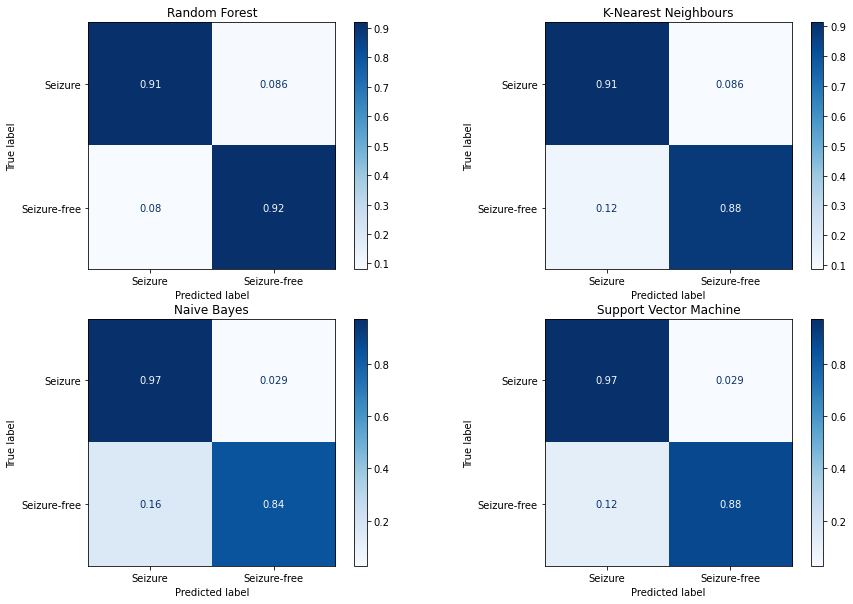

In [23]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=seed)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

for clf,ax,name in zip(classifiers, axes.flatten(),names):
    pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=selected_funcs)),('clf', clf)])
    pipe.fit(X_train,y_train)

    plot_confusion_matrix(pipe, X_test, y_test,
                        display_labels=['Seizure','Seizure-free'],
                        cmap=plt.cm.Blues,
                        normalize='true',ax=ax)
    ax.title.set_text(name)
plt.show()

In this comparison, the RF classifier doesn't have the highest accuracy. However, it has the lowest False Positive rate. This is very important in an application like this, because we don't want a system that constantly injects a drug or uses electric stimulation when it isn't necessary. 

### Question 2

Why did you choose the four indicated features? Which of these is the most effective taken by itself, according to you?

The four features were chosen based on a seizure detection example. The example showed how MNE-Features could be used to design an efficient seizure detection algorithm. See: https://mne.tools/mne-features/auto_examples/plot_seizure_example.html. 

First, I compared the effectiveness of these features by 1) training all classifiers on each of them separately and 2) calculating the average score of each feature.

In [25]:
selected_funcs = ['line_length', 'kurtosis', 'ptp_amp', 'skewness']

skf = StratifiedKFold(n_splits=5)
seed = 26

names = ['Random Forest','K-Nearest Neighbours','Naive Bayes','Support Vector Machine']
classifiers = [RandomForestClassifier(n_estimators=100,max_depth=4,random_state=seed),KNeighborsClassifier(n_neighbors=10),GaussianNB(),SVC(kernel="linear",C=0.025,random_state=seed)]


In [32]:
for j in range(len(selected_funcs)):
    scores=[]
    for i in range(len(names)):
        pipe = Pipeline([('fe', FeatureExtractor(sfreq=sfreq,selected_funcs=[selected_funcs[j]])),('clf', classifiers[i])])
        scores.append(cross_val_score(pipe, data, y, cv=skf))
    print('=====================================================')
    print('Feature used:',selected_funcs[j])   
    print('Average cross-validation accuracy score = %1.3f (+/- %1.5f)' % (np.mean(scores),np.std(scores)))
print('=====================================================')

Feature used: line_length
Average cross-validation accuracy score = 0.933 (+/- 0.02005)
Feature used: kurtosis
Average cross-validation accuracy score = 0.683 (+/- 0.02687)
Feature used: ptp_amp
Average cross-validation accuracy score = 0.892 (+/- 0.02861)
Feature used: skewness
Average cross-validation accuracy score = 0.664 (+/- 0.03174)


The results showed that out of all features, line_length was the most useful feature for seizure onset detection. This is in line with previous research of Esteller and colleagues (2001). The authors evaluated this feature over iEEG signals from 10 patients and found that line_length was a useful and efficient feature for this task. 

Esteller, R., Echauz, J., Tcheng, T., Litt, B., & Pless, B. (2001, October). Line length: an efficient feature for seizure onset detection. In 2001 Conference Proceedings of the 23rd Annual International Conference of the IEEE Engineering in Medicine and Biology Society (Vol. 2, pp. 1707-1710). IEEE.)